In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv('cmc_train.csv')

train_labels = df['label']
train_labels = np.array(train_labels)
print(train_labels)

train_features = df.iloc[:,:9]
train_features = np.array(train_features)
print(train_features)

print('train_features', train_features.shape)
print('train_labels', train_labels.shape)

df = pd.read_csv('cmc_test.csv')

test_labels = df['label']
test_labels = np.array(test_labels)
print(test_labels)

test_features = df.iloc[:,:9]
test_features = np.array(test_features)
print(test_features)

print('test_features', test_features.shape)
print('test_labels', test_labels.shape)

[1 1 1 ... 3 3 3]
[[24  2  3 ...  2  3  0]
 [45  1  3 ...  3  4  0]
 [43  2  3 ...  3  4  0]
 ...
 [39  3  3 ...  1  4  0]
 [33  3  3 ...  2  2  0]
 [17  3  3 ...  2  4  0]]
train_features (1327, 9)
train_labels (1327,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[[33  4  4 ...  3  3  0]
 [32  2  4 ...  3  3  0]
 [45  1  1 ...  2  2  1]
 ...
 [37  4  4 ...  3  4  0]
 [27  2  2 ...  3  1  0]
 [28  4  4 ...  1  3  0]]
test_features (146, 9)
test_labels (146,)


In [5]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from vecstack import stacking
from sklearn.model_selection import GridSearchCV,ParameterGrid
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import warnings

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')


In [20]:
#获取准确率最高的rel_knn_algorithm、rel_weight和rel_nearest_neighbor
from sklearn import neighbors,decomposition
rel_nearest_neighbor = 0
rel_knn_algorithm = ''
rel_weight = ''
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
rel_pre = -1

for knn_algorithm in knn_algorithms:
    #nearest_neighbor参数范围为1-20
    for nearest_neighbor in range(1,201):
        for weight in weights:
            clf = neighbors.KNeighborsClassifier(n_neighbors = nearest_neighbor, weights=weight, algorithm=knn_algorithm)
            clf = clf.fit(train_features, train_labels)

            pre = clf.predict(test_features)
            accuracy = np.sum(pre == test_labels) / pre.shape[0]
            #print('knn_algorithm =',knn_algorithm,',nearest_neighbors =', nearest_neighbor,',weight =',weight,  ',accuracy=', accuracy)
            if accuracy > rel_pre:
                rel_pre = accuracy
                rel_knn_algorithm =knn_algorithm
                rel_weight = weight
                rel_nearest_neighbor = nearest_neighbor

print('rel_knn_algorithm：',rel_knn_algorithm)
print('rel_weight：',rel_weight)
print('rel_nearest_neighbor：',rel_nearest_neighbor)
print('rel_pre：',rel_pre)
from sklearn import neighbors,decomposition
knn_cv = neighbors.KNeighborsClassifier(n_neighbors = rel_nearest_neighbor, weights=rel_weight,
                                     algorithm=rel_knn_algorithm)

rel_knn_algorithm： ball_tree
rel_weight： uniform
rel_nearest_neighbor： 40
rel_pre： 0.5958904109589042


In [16]:
from sklearn import tree
rel_max_depth = 0
rel_min_samples_leaf = 0
rel_pre = -1

for max_depth in range(1,101,1):
    for min_samples_leaf in range(1,101,1):
        clf = tree.DecisionTreeClassifier(max_depth = max_depth,min_samples_leaf =min_samples_leaf)
        clf = clf.fit(train_features, train_labels)

        pre = clf.predict(test_features)
        accuracy = np.sum(pre == test_labels) / pre.shape[0]
#        print('max_depth =',max_depth,',min_samples_leaf =', min_samples_leaf,'accuracy=', accuracy)
        if accuracy > rel_pre:
            rel_pre = accuracy
            rel_max_depth =max_depth
            rel_min_samples_leaf = min_samples_leaf
            
dt_cv = tree.DecisionTreeClassifier(max_depth = rel_max_depth,min_samples_leaf =rel_min_samples_leaf)
print('rel_pre：',rel_pre)
print('rel_max_depth：',rel_max_depth)
print('rel_min_samples_leaf：',rel_min_samples_leaf)  

rel_pre： 0.6027397260273972
rel_max_depth： 7
rel_min_samples_leaf： 21


In [17]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
# 创建分类器对象
clf = GaussianNB()
#用训练数据拟合分类器模型
nb_sv = clf.fit(train_features.astype(np.float64), train_labels)

In [9]:
# 模型融合
model_list = [knn_cv,dt_cv,nb_sv]
rel_n_folds = 0
rel_pre = -1
rel_pred = []
x = []
y = []

for n_fold in range(350,452, 2):
    S_train, S_test = stacking(model_list, train_features, train_labels,test_features, regression=False, n_folds=n_fold)
    # # Initialize 2-nd level model
    model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)
    # # Fit 2-nd level model
    model_s = model.fit(S_train, train_labels)
    # # Predict
    y_pred = model_s.predict(S_test)
    # Final prediction score
    accuracy = metrics.accuracy_score(test_labels, y_pred)
    x.append(n_fold)
    y.append(accuracy)
    print('n_folds =',n_fold,'accuracy=', accuracy)
    if accuracy >= rel_pre:
        rel_pre = accuracy
        rel_n_folds = n_fold
        rel_pred = y_pred
        
# acc_score_test = metrics.accuracy_score(y_pred, test_labels)
# precision_score_test = metrics.precision_score(y_pred, test_labels, average="micro")
# recall_score_test = metrics.recall_score(y_pred, test_labels, average="micro")
# f1_score_test = metrics.f1_score(y_pred, test_labels, average="micro")

# # scoring='roc_auc'是用来检测定性数据结果的，比如好人坏人，是和否等，即结果为0或1的数据预测
# # roc_auc_score_test = metrics.roc_auc_score(y_pred, test_labels,average="micro")

# print('Final 测试集准确率：{}\n'.format(acc_score_test))
# print('Final 测试集精确率：{}\n'.format(precision_score_test))
# print('Final 测试集召回率：{}\n'.format(recall_score_test))
# print('Final 测试集f1评分：{}\n'.format(f1_score_test))
# print('Final 测试集AUC值：{}\n'.format(roc_auc_score_test))
        
        

# model_est(model_dict_s, x_train, x_test, y_train, y_test) 



n_folds = 350 accuracy= 0.5753424657534246
n_folds = 352 accuracy= 0.5753424657534246
n_folds = 354 accuracy= 0.5753424657534246
n_folds = 356 accuracy= 0.5753424657534246
n_folds = 358 accuracy= 0.5684931506849316
n_folds = 360 accuracy= 0.5684931506849316
n_folds = 362 accuracy= 0.5753424657534246
n_folds = 364 accuracy= 0.5753424657534246
n_folds = 366 accuracy= 0.5753424657534246
n_folds = 368 accuracy= 0.5753424657534246
n_folds = 370 accuracy= 0.5753424657534246
n_folds = 372 accuracy= 0.5753424657534246
n_folds = 374 accuracy= 0.5821917808219178
n_folds = 376 accuracy= 0.589041095890411
n_folds = 378 accuracy= 0.589041095890411
n_folds = 380 accuracy= 0.589041095890411
n_folds = 382 accuracy= 0.589041095890411
n_folds = 384 accuracy= 0.589041095890411
n_folds = 386 accuracy= 0.589041095890411
n_folds = 388 accuracy= 0.589041095890411
n_folds = 390 accuracy= 0.589041095890411
n_folds = 392 accuracy= 0.589041095890411
n_folds = 394 accuracy= 0.589041095890411
n_folds = 396 accurac

In [10]:
print(rel_pred)
print(test_labels)

[1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1
 1 1 3 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 3 3 1 1 1 3 1 3 2 1 3 1
 3 3 3 3 1 1 3 3 2 3 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1
 1 3 1 1 1 1 1 2 1 3 3 1 3 1 3 2 1 1 3 1 1 3 1 1 1 2 3 1 1 1 1 1 3 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


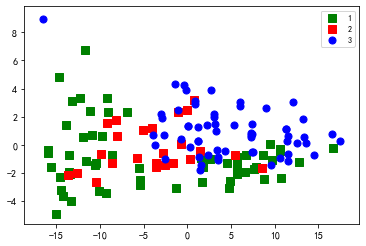

In [13]:
import matplotlib.pyplot as plt
import time
def plotBestFit(data0,data1, data2):

    a = np.shape(data0)[0]
    b = np.shape(data1)[0]
    c = np.shape(data2)[0]

    
    axis_x0 = []
    axis_y0 = []    
    axis_x1 = []
    axis_y1 = []
    axis_x2 = []
    axis_y2 = []

    
    for aa in range(a):
        axis_x0.append(data0[aa,0])
        axis_y0.append(data0[aa,1])
    for bb in range(b):
        axis_x1.append(data1[bb,0])
        axis_y1.append(data1[bb,1])
    for cc in range(c):
        axis_x2.append(data2[cc,0])
        axis_y2.append(data2[cc,1])
     
        
    fig = plt.figure()
    #ax = Axes3D(fig)
    ax = fig.add_subplot(111)
    ax.scatter(axis_x0, axis_y0, s=50, c='green', marker='s')
    ax.scatter(axis_x1, axis_y1, s=50, c='red', marker='s')
    ax.scatter(axis_x2, axis_y2,s=50, c='blue')


    
    #plt.xlabel('x1'); plt.ylabel('x2');
    # ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    # ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    # ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
    # ax.scatter(axis_x1, axis_y1,axis_z1,  c='red', marker='s')
    # ax.scatter(axis_x2, axis_y2, axis_z2, c='blue')
    plt.legend(fontsize='small',labels=[ '1','2','3'])  
    plt.savefig("模型融合-cmc-二维点图.png")
    plt.show()
    
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(test_features.astype(np.float64))
plotBestFit(X_pca[y_pred == 1],X_pca[y_pred == 2],X_pca[y_pred == 3])

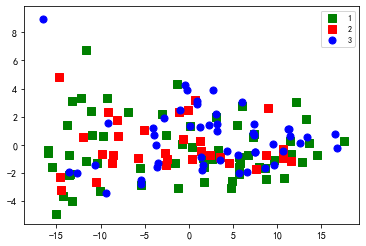

In [16]:
plotBestFit(X_pca[ test_labels == 1],X_pca[ test_labels == 2],X_pca[ test_labels == 3])

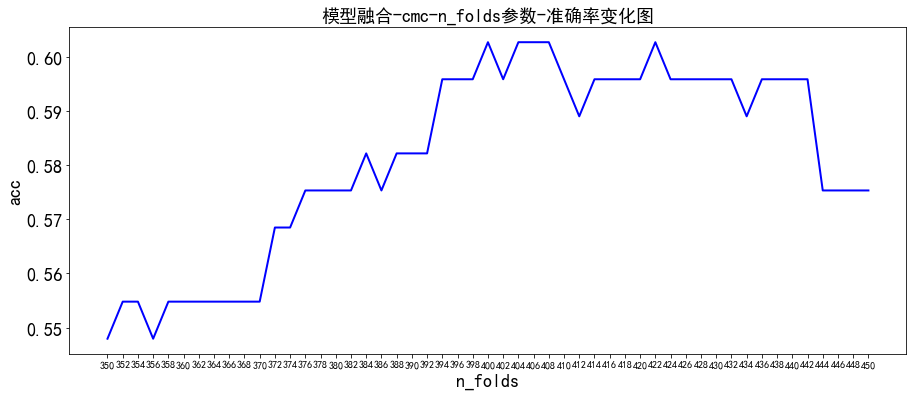

In [17]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

#X轴，Y轴数据
# x = [0,1,2,3,4,5,6]
# y = [0.3,0.4,2,5,3,4.5,4]
plt.figure(figsize=(15,6)) #创建绘图对象
plt.plot(x,y,"b",linewidth=2)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
plt.xticks(x, x)
plt.yticks(size=18)
plt.xlabel("n_folds",size=18) #X轴标签
plt.ylabel("acc",size=18)  #Y轴标签
plt.title("模型融合-cmc-n_folds参数-准确率变化图",size=18) #图标题
# 设置数字标签
# for a, b in zip(x, y):
#     plt.text(a, b, b, ha='center', va='bottom')



plt.savefig("模型融合-cmc-n_folds参数选择图.png") #保存图
plt.show()  #显示图

In [27]:
# 模型融合
model_list = [knn_cv,dt_cv,nb_sv]
S_train, S_test = stacking(model_list, train_features, train_labels,test_features, regression=False, n_folds=400)

# # Initialize 2-nd level model
model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)

# # Fit 2-nd level model
model_s = model.fit(S_train, train_labels)

# # Predict
y_pred = model_s.predict(S_test)

# Final prediction score
# print('Final prediction score: [%.8f]' % metrics.accuracy_score(y_test, y_pred))
acc_score_test = metrics.accuracy_score(y_pred, test_labels)
precision_score_test = metrics.precision_score(y_pred, test_labels,average="micro")
recall_score_test = metrics.recall_score(y_pred, test_labels,average="micro")
f1_score_test = metrics.f1_score(y_pred, test_labels,average="micro")
# roc_auc_score_test = metrics.roc_auc_score(y_pred, test_labels)

print('Final 测试集准确率：{}\n'.format(acc_score_test))
print('Final 测试集精确率：{}\n'.format(precision_score_test))
print('Final 测试集召回率：{}\n'.format(recall_score_test))
print('Final 测试集f1评分：{}\n'.format(f1_score_test))
# print('Final 测试集AUC值：{}\n'.format(roc_auc_score_test))
        
        

# model_est(model_dict_s, x_train, x_test, y_train, y_test) 



Final 测试集准确率：0.589041095890411

Final 测试集精确率：0.589041095890411

Final 测试集召回率：0.589041095890411

Final 测试集f1评分：0.589041095890411

